# Baseline Results

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score
from sklearn.model_selection import KFold
from tensorflow.keras.layers import Input, LSTM, Dense, Flatten, TimeDistributed, Conv1D, BatchNormalization, MaxPooling1D, Bidirectional, Concatenate
from tensorflow.keras import Model
from tensorflow.keras.initializers import Constant
from keras.layers.advanced_activations import PReLU

import sys
module_path = os.path.abspath(os.getcwd() + '\\..')
if module_path not in sys.path:
    sys.path.append(module_path)
from src.data.load_dataset import load_dataset, load_fusioned_dataset

In [2]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=50,
    restore_best_weights=True,
)

In [3]:
epochs, batch_size = 25, 32
kf = KFold(n_splits=3, shuffle=True, random_state=48)
cnn_auc = []
rnn_auc = []

## 1. Unimodal Body Modality (Skeleton)

### Dataset

In [4]:
X_train, X_test, y_train, y_test = load_dataset('skeleton', binary=True)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(812, 1, 350, 35) (812, 1)
(245, 1, 350, 35) (245, 1)


### CNN + Bidirectional LSTM

In [5]:
class CNNLSTM():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'))(input)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(conv1d)
        flatten = TimeDistributed(Flatten())(maxpool)
        lstm = Bidirectional(LSTM(64, activation='relu'))(flatten)
        dense = Dense(64, activation='relu')(lstm)
        output = Dense(units=n_outputs, activation='sigmoid')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 3s - loss: 5.0012 - accuracy: 0.4954 - auc: 0.4814 - precision: 0.5016 - recall: 0.5803 - f1_score: 0.6724 - val_loss: 1.5214 - val_accuracy: 0.5018 - val_auc: 0.5125 - val_precision: 0.5000 - val_recall: 0.0815 - val_f1_score: 0.6650 - 3s/epoch - 206ms/step
Epoch 2/25
17/17 - 1s - loss: 1.1312 - accuracy: 0.5360 - auc: 0.5529 - precision: 0.5481 - recall: 0.4781 - f1_score: 0.6724 - val_loss: 1.1334 - val_accuracy: 0.5424 - val_auc: 0.5879 - val_precision: 0.5224 - val_recall: 0.9481 - val_f1_score: 0.6650 - 790ms/epoch - 46ms/step
Epoch 3/25
17/17 - 1s - loss: 0.9347 - accuracy: 0.5397 - auc: 0.5510 - precision: 0.5451 - recall: 0.5511 - f1_score: 0.6724 - val_loss: 0.8882 - val_accuracy: 0.5720 - val_auc: 0.6203 - val_precision: 0.5415 - val_recall: 0.9185 - val_f1_score: 0.6650 - 771ms/epoch - 45ms/step
Epoch 4/25
17/17 - 1s - loss: 0.7561 - accuracy: 0.5749 - auc: 0.6227 - precision: 0.5748 - recall: 0.6168 - f1_score: 0.6724 - val_loss: 0.7415 - val_accuracy: 0

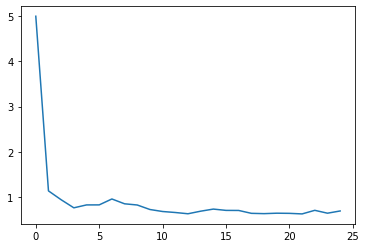

Epoch 1/25
17/17 - 4s - loss: 7.7055 - accuracy: 0.4566 - auc_1: 0.4493 - precision_1: 0.4494 - recall_1: 0.4494 - f1_score: 0.6418 - val_loss: 1.3160 - val_accuracy: 0.4760 - val_auc_1: 0.4645 - val_precision_1: 0.5000 - val_recall_1: 0.7042 - val_f1_score: 0.6877 - 4s/epoch - 213ms/step
Epoch 2/25
17/17 - 1s - loss: 1.3175 - accuracy: 0.5323 - auc_1: 0.5181 - precision_1: 0.5241 - recall_1: 0.5693 - f1_score: 0.6609 - val_loss: 1.1096 - val_accuracy: 0.5720 - val_auc_1: 0.6021 - val_precision_1: 0.5707 - val_recall_1: 0.7394 - val_f1_score: 0.6877 - 824ms/epoch - 48ms/step
Epoch 3/25
17/17 - 1s - loss: 1.8157 - accuracy: 0.5102 - auc_1: 0.5311 - precision_1: 0.5034 - recall_1: 0.5581 - f1_score: 0.6609 - val_loss: 1.4719 - val_accuracy: 0.5351 - val_auc_1: 0.6102 - val_precision_1: 0.7857 - val_recall_1: 0.1549 - val_f1_score: 0.6877 - 1s/epoch - 61ms/step
Epoch 4/25
17/17 - 1s - loss: 1.3058 - accuracy: 0.5896 - auc_1: 0.5814 - precision_1: 0.5849 - recall_1: 0.5805 - f1_score: 0.66

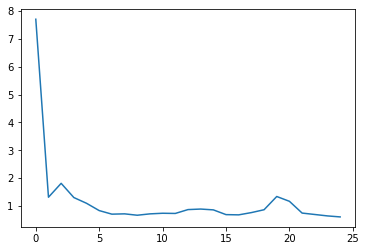

Epoch 1/25
17/17 - 3s - loss: 9.5772 - accuracy: 0.4889 - auc_2: 0.4825 - precision_2: 0.5000 - recall_2: 0.4946 - f1_score: 0.6375 - val_loss: 2.4644 - val_accuracy: 0.5296 - val_auc_2: 0.5206 - val_precision_2: 0.5150 - val_recall_2: 0.6515 - val_f1_score: 0.6567 - 3s/epoch - 195ms/step
Epoch 2/25
17/17 - 1s - loss: 2.3603 - accuracy: 0.5018 - auc_2: 0.5097 - precision_2: 0.5123 - recall_2: 0.5271 - f1_score: 0.6764 - val_loss: 1.7023 - val_accuracy: 0.5296 - val_auc_2: 0.5530 - val_precision_2: 0.5140 - val_recall_2: 0.6970 - val_f1_score: 0.6567 - 754ms/epoch - 44ms/step
Epoch 3/25
17/17 - 1s - loss: 1.4069 - accuracy: 0.5793 - auc_2: 0.5946 - precision_2: 0.5904 - recall_2: 0.5776 - f1_score: 0.6764 - val_loss: 1.3408 - val_accuracy: 0.5259 - val_auc_2: 0.5850 - val_precision_2: 0.5116 - val_recall_2: 0.6667 - val_f1_score: 0.6567 - 768ms/epoch - 45ms/step
Epoch 4/25
17/17 - 1s - loss: 3.1060 - accuracy: 0.5498 - auc_2: 0.5539 - precision_2: 0.5613 - recall_2: 0.5451 - f1_score: 0

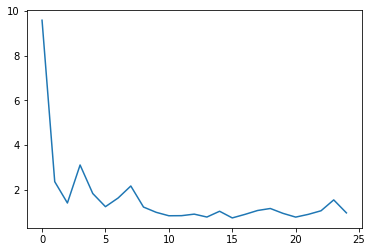

In [6]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    cnnlstm_binary_body_model = CNNLSTM(n_features, n_length, n_outputs)
    history = cnnlstm_binary_body_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [7]:
y_pred = cnnlstm_binary_body_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_binary_body_model.evaluate(X_test, y_test)
cnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Accuracy: 77.55% 
ROC/AUC: 0.70 
Precision: 0.88 
Recall: 0.85 
F1 score: 0.91


### RCNN

In [8]:
class RCNN():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input)
        bn = TimeDistributed(BatchNormalization())(conv1d)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn)
        flatten = Flatten()(maxpool)
        dense = Dense(64, activation=PReLU(alpha_initializer=Constant(value=0.25)))(flatten)
        output = Dense(units=n_outputs, activation='sigmoid')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 2s - loss: 0.8502 - accuracy: 0.5823 - auc_3: 0.6369 - precision_3: 0.5811 - recall_3: 0.6277 - f1_score: 0.6724 - val_loss: 6.9479 - val_accuracy: 0.5018 - val_auc_3: 0.5000 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_f1_score: 0.6650 - 2s/epoch - 98ms/step
Epoch 2/25
17/17 - 0s - loss: 0.6483 - accuracy: 0.6377 - auc_3: 0.7164 - precision_3: 0.6573 - recall_3: 0.5949 - f1_score: 0.6724 - val_loss: 3.0287 - val_accuracy: 0.5018 - val_auc_3: 0.5814 - val_precision_3: 0.5000 - val_recall_3: 1.0000 - val_f1_score: 0.6650 - 424ms/epoch - 25ms/step
Epoch 3/25
17/17 - 0s - loss: 0.6036 - accuracy: 0.6636 - auc_3: 0.7375 - precision_3: 0.6769 - recall_3: 0.6423 - f1_score: 0.6724 - val_loss: 4.2842 - val_accuracy: 0.4982 - val_auc_3: 0.5111 - val_precision_3: 0.4982 - val_recall_3: 1.0000 - val_f1_score: 0.6650 - 453ms/epoch - 27ms/step
Epoch 4/25
17/17 - 0s - loss: 0.5956 - accuracy: 0.6802 - auc_3: 0.7581 - precision_3: 0.6877 - recall_3: 0.6752 - f1_s

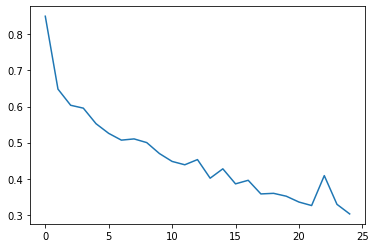

Epoch 1/25
17/17 - 2s - loss: 0.8578 - accuracy: 0.5915 - auc_4: 0.6235 - precision_4: 0.5799 - recall_4: 0.6255 - f1_score: 0.6609 - val_loss: 3.3989 - val_accuracy: 0.4760 - val_auc_4: 0.4565 - val_precision_4: 0.5000 - val_recall_4: 0.1056 - val_f1_score: 0.6877 - 2s/epoch - 113ms/step
Epoch 2/25
17/17 - 0s - loss: 0.6814 - accuracy: 0.6137 - auc_4: 0.6831 - precision_4: 0.6261 - recall_4: 0.5393 - f1_score: 0.6609 - val_loss: 3.7195 - val_accuracy: 0.5240 - val_auc_4: 0.5202 - val_precision_4: 0.5240 - val_recall_4: 1.0000 - val_f1_score: 0.6877 - 426ms/epoch - 25ms/step
Epoch 3/25
17/17 - 0s - loss: 0.6175 - accuracy: 0.7079 - auc_4: 0.7704 - precision_4: 0.6775 - recall_4: 0.7790 - f1_score: 0.6609 - val_loss: 1.7490 - val_accuracy: 0.5203 - val_auc_4: 0.6159 - val_precision_4: 0.5233 - val_recall_4: 0.9507 - val_f1_score: 0.6877 - 390ms/epoch - 23ms/step
Epoch 4/25
17/17 - 0s - loss: 0.5846 - accuracy: 0.6895 - auc_4: 0.7736 - precision_4: 0.7143 - recall_4: 0.6180 - f1_score: 0

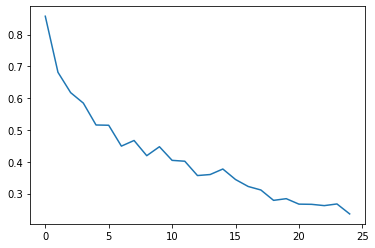

Epoch 1/25
17/17 - 2s - loss: 0.7795 - accuracy: 0.6199 - auc_5: 0.6610 - precision_5: 0.6300 - recall_5: 0.6209 - f1_score: 0.6764 - val_loss: 1.9521 - val_accuracy: 0.5370 - val_auc_5: 0.6094 - val_precision_5: 0.8182 - val_recall_5: 0.0682 - val_f1_score: 0.6567 - 2s/epoch - 92ms/step
Epoch 2/25
17/17 - 0s - loss: 0.6301 - accuracy: 0.6827 - auc_5: 0.7379 - precision_5: 0.6937 - recall_5: 0.6787 - f1_score: 0.6764 - val_loss: 4.4348 - val_accuracy: 0.4889 - val_auc_5: 0.5324 - val_precision_5: 0.4889 - val_recall_5: 1.0000 - val_f1_score: 0.6567 - 437ms/epoch - 26ms/step
Epoch 3/25
17/17 - 0s - loss: 0.5946 - accuracy: 0.7048 - auc_5: 0.7698 - precision_5: 0.7159 - recall_5: 0.7004 - f1_score: 0.6764 - val_loss: 2.4033 - val_accuracy: 0.5148 - val_auc_5: 0.5903 - val_precision_5: 0.5020 - val_recall_5: 0.9394 - val_f1_score: 0.6567 - 411ms/epoch - 24ms/step
Epoch 4/25
17/17 - 0s - loss: 0.5446 - accuracy: 0.7325 - auc_5: 0.8041 - precision_5: 0.7519 - recall_5: 0.7112 - f1_score: 0.

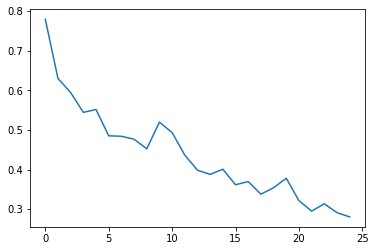

In [9]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    rcnn_binary_body_model = RCNN(n_features, n_length, n_outputs)
    history = rcnn_binary_body_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [10]:
y_pred = rcnn_binary_body_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_binary_body_model.evaluate(X_test, y_test)
rnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Accuracy: 55.51% 
ROC/AUC: 0.69 
Precision: 0.91 
Recall: 0.52 
F1 score: 0.91


## 2. Unimodal Face Modality (Action Units + Head Pose)

### Dataset

In [11]:
X_train, X_test, y_train, y_test = load_dataset('AUs', binary=True)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(782, 1, 350, 25) (782, 1)
(238, 1, 350, 25) (238, 1)


### CNN + Bidirectional LSTM

In [12]:
class CNNLSTM():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'))(input)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(conv1d)
        flatten = TimeDistributed(Flatten())(maxpool)
        lstm = Bidirectional(LSTM(64, activation='relu'))(flatten)
        dense = Dense(64, activation='relu')(lstm)
        output = Dense(units=n_outputs, activation='sigmoid')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 3s - loss: 9415.8916 - accuracy: 0.4875 - auc_6: 0.4783 - precision_6: 0.4987 - recall_6: 0.7218 - f1_score: 0.6145 - val_loss: 20694.4961 - val_accuracy: 0.5172 - val_auc_6: 0.5395 - val_precision_6: 0.5484 - val_recall_6: 0.1318 - val_f1_score: 0.6190 - 3s/epoch - 177ms/step
Epoch 2/25
17/17 - 1s - loss: 3048.2876 - accuracy: 0.4990 - auc_6: 0.4944 - precision_6: 0.5064 - recall_6: 0.7444 - f1_score: 0.6622 - val_loss: 10522.2764 - val_accuracy: 0.4981 - val_auc_6: 0.5072 - val_precision_6: 0.4961 - val_recall_6: 0.9767 - val_f1_score: 0.6580 - 755ms/epoch - 44ms/step
Epoch 3/25
17/17 - 1s - loss: 2703.1182 - accuracy: 0.5221 - auc_6: 0.5176 - precision_6: 0.5268 - recall_6: 0.6278 - f1_score: 0.6303 - val_loss: 20349.8223 - val_accuracy: 0.5057 - val_auc_6: 0.5001 - val_precision_6: 0.5000 - val_recall_6: 0.0078 - val_f1_score: 0.0303 - 716ms/epoch - 42ms/step
Epoch 4/25
17/17 - 1s - loss: 7212.5552 - accuracy: 0.5048 - auc_6: 0.5086 - precision_6: 0.5167 - recall

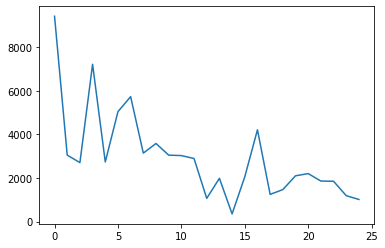

Epoch 1/25
17/17 - 4s - loss: 21076.6641 - accuracy: 0.5106 - auc_7: 0.5080 - precision_7: 0.5046 - recall_7: 0.6318 - f1_score: 0.5854 - val_loss: 5870.6484 - val_accuracy: 0.4751 - val_auc_7: 0.5061 - val_precision_7: 0.5000 - val_recall_7: 0.0146 - val_f1_score: 0.1850 - 4s/epoch - 224ms/step
Epoch 2/25
17/17 - 1s - loss: 11352.9512 - accuracy: 0.5221 - auc_7: 0.5220 - precision_7: 0.5126 - recall_7: 0.7093 - f1_score: 0.6277 - val_loss: 2651.9612 - val_accuracy: 0.5211 - val_auc_7: 0.4968 - val_precision_7: 0.5233 - val_recall_7: 0.9854 - val_f1_score: 0.6869 - 809ms/epoch - 48ms/step
Epoch 3/25
17/17 - 1s - loss: 10043.5840 - accuracy: 0.4683 - auc_7: 0.4780 - precision_7: 0.4749 - recall_7: 0.6977 - f1_score: 0.6089 - val_loss: 134.6162 - val_accuracy: 0.4674 - val_auc_7: 0.4722 - val_precision_7: 0.4500 - val_recall_7: 0.0657 - val_f1_score: 0.3565 - 813ms/epoch - 48ms/step
Epoch 4/25
17/17 - 1s - loss: 1992.7637 - accuracy: 0.4971 - auc_7: 0.5021 - precision_7: 0.4926 - recall_

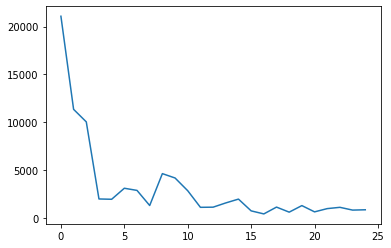

Epoch 1/25
17/17 - 4s - loss: 9298.3115 - accuracy: 0.5057 - auc_8: 0.5068 - precision_8: 0.5152 - recall_8: 0.5113 - f1_score: 0.5888 - val_loss: 19989.8418 - val_accuracy: 0.5769 - val_auc_8: 0.5980 - val_precision_8: 0.5473 - val_recall_8: 0.8527 - val_f1_score: 0.6684 - 4s/epoch - 234ms/step
Epoch 2/25
17/17 - 1s - loss: 1566.8987 - accuracy: 0.5709 - auc_8: 0.5846 - precision_8: 0.5795 - recall_8: 0.5752 - f1_score: 0.6803 - val_loss: 3341.6250 - val_accuracy: 0.4615 - val_auc_8: 0.4788 - val_precision_8: 0.4267 - val_recall_8: 0.2481 - val_f1_score: 0.6614 - 885ms/epoch - 52ms/step
Epoch 3/25
17/17 - 1s - loss: 128.2595 - accuracy: 0.5307 - auc_8: 0.5308 - precision_8: 0.5241 - recall_8: 0.8571 - f1_score: 0.6796 - val_loss: 49428.6250 - val_accuracy: 0.5000 - val_auc_8: 0.5038 - val_precision_8: 0.4981 - val_recall_8: 1.0000 - val_f1_score: 0.6649 - 852ms/epoch - 50ms/step
Epoch 4/25
17/17 - 1s - loss: 288.3958 - accuracy: 0.5211 - auc_8: 0.5117 - precision_8: 0.5155 - recall_8:

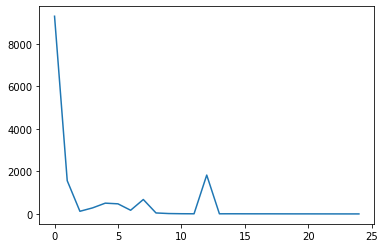

In [13]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    cnnlstm_binary_face_model = CNNLSTM(n_features, n_length, n_outputs)
    history = cnnlstm_binary_face_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

##### Prediction on the holdout set

In [14]:
y_pred = cnnlstm_binary_face_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_binary_face_model.evaluate(X_test, y_test)
cnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Accuracy: 65.97% 
ROC/AUC: 0.57 
Precision: 0.87 
Recall: 0.70 
F1 score: 0.90


### RCNN

In [15]:
class RCNN():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input)
        bn = TimeDistributed(BatchNormalization())(conv1d)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn)
        flatten = Flatten()(maxpool)
        dense = Dense(64, activation=PReLU(alpha_initializer=Constant(value=0.25)))(flatten)
        output = Dense(units=n_outputs, activation='sigmoid')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 2s - loss: 1.0338 - accuracy: 0.5547 - auc_9: 0.5602 - precision_9: 0.5714 - recall_9: 0.5113 - f1_score: 0.6760 - val_loss: 1.2281 - val_accuracy: 0.5019 - val_auc_9: 0.4925 - val_precision_9: 0.3333 - val_recall_9: 0.0078 - val_f1_score: 0.6546 - 2s/epoch - 122ms/step
Epoch 2/25
17/17 - 0s - loss: 0.7920 - accuracy: 0.5720 - auc_9: 0.5819 - precision_9: 0.6019 - recall_9: 0.4774 - f1_score: 0.6760 - val_loss: 1.4509 - val_accuracy: 0.5057 - val_auc_9: 0.5386 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00 - val_f1_score: 0.6546 - 441ms/epoch - 26ms/step
Epoch 3/25
17/17 - 0s - loss: 0.7647 - accuracy: 0.5528 - auc_9: 0.6080 - precision_9: 0.5864 - recall_9: 0.4211 - f1_score: 0.6760 - val_loss: 0.7218 - val_accuracy: 0.5172 - val_auc_9: 0.5176 - val_precision_9: 0.8000 - val_recall_9: 0.0310 - val_f1_score: 0.6615 - 425ms/epoch - 25ms/step
Epoch 4/25
17/17 - 0s - loss: 0.6878 - accuracy: 0.5547 - auc_9: 0.5998 - precision_9: 0.6308 - recall_9: 0.3083 - f1_

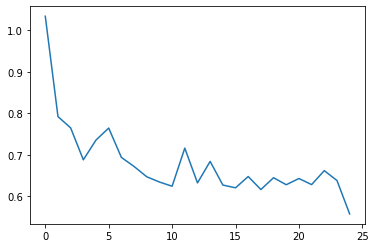

Epoch 1/25
17/17 - 2s - loss: 0.8943 - accuracy: 0.4779 - auc_10: 0.4976 - precision_10: 0.4803 - recall_10: 0.6628 - f1_score: 0.6624 - val_loss: 0.7778 - val_accuracy: 0.5211 - val_auc_10: 0.5578 - val_precision_10: 0.5233 - val_recall_10: 0.9854 - val_f1_score: 0.6884 - 2s/epoch - 128ms/step
Epoch 2/25
17/17 - 0s - loss: 0.7673 - accuracy: 0.5528 - auc_10: 0.5814 - precision_10: 0.5364 - recall_10: 0.7132 - f1_score: 0.6624 - val_loss: 0.6833 - val_accuracy: 0.4866 - val_auc_10: 0.5655 - val_precision_10: 1.0000 - val_recall_10: 0.0219 - val_f1_score: 0.6884 - 414ms/epoch - 24ms/step
Epoch 3/25
17/17 - 0s - loss: 0.7573 - accuracy: 0.5393 - auc_10: 0.5667 - precision_10: 0.5882 - recall_10: 0.2326 - f1_score: 0.6624 - val_loss: 0.6835 - val_accuracy: 0.5287 - val_auc_10: 0.5149 - val_precision_10: 0.5269 - val_recall_10: 1.0000 - val_f1_score: 0.6884 - 405ms/epoch - 24ms/step
Epoch 4/25
17/17 - 0s - loss: 0.7320 - accuracy: 0.5298 - auc_10: 0.5982 - precision_10: 0.5135 - recall_10:

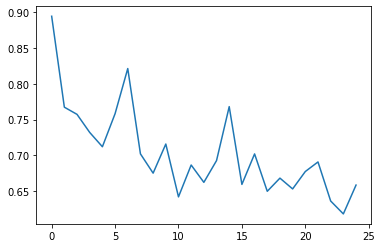

Epoch 1/25
17/17 - 2s - loss: 0.9738 - accuracy: 0.5019 - auc_11: 0.5322 - precision_11: 0.5115 - recall_11: 0.5038 - f1_score: 0.6751 - val_loss: 1.0131 - val_accuracy: 0.5000 - val_auc_11: 0.4925 - val_precision_11: 0.4981 - val_recall_11: 1.0000 - val_f1_score: 0.6632 - 2s/epoch - 93ms/step
Epoch 2/25
17/17 - 0s - loss: 0.7359 - accuracy: 0.5364 - auc_11: 0.5394 - precision_11: 0.5290 - recall_11: 0.8233 - f1_score: 0.6751 - val_loss: 1.0068 - val_accuracy: 0.4885 - val_auc_11: 0.5217 - val_precision_11: 0.4907 - val_recall_11: 0.8217 - val_f1_score: 0.6632 - 391ms/epoch - 23ms/step
Epoch 3/25
17/17 - 0s - loss: 0.6972 - accuracy: 0.5632 - auc_11: 0.6119 - precision_11: 0.5525 - recall_11: 0.7519 - f1_score: 0.6751 - val_loss: 0.7527 - val_accuracy: 0.4962 - val_auc_11: 0.5191 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00 - val_f1_score: 0.6632 - 385ms/epoch - 23ms/step
Epoch 4/25
17/17 - 0s - loss: 0.6615 - accuracy: 0.5900 - auc_11: 0.6277 - precision_11: 0.5714 - rec

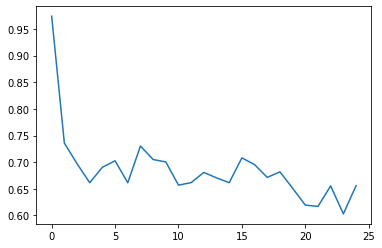

In [16]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    rcnn_binary_face_model = RCNN(n_features, n_length, n_outputs)
    history = rcnn_binary_face_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

#### Evaluation on the holdout set

In [17]:
y_pred = rcnn_binary_face_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_binary_face_model.evaluate(X_test, y_test)
rnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Accuracy: 84.45% 
ROC/AUC: 0.55 
Precision: 0.85 
Recall: 0.99 
F1 score: 0.92


## 3. Multimodal Early Fusion

### Dataset

In [18]:
X_train, X_test, y_train, y_test = load_fusioned_dataset(binary=True)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(782, 1, 350, 60) (782, 1)
(238, 1, 350, 60) (238, 1)


### CNN + Bidirectional LSTM

In [19]:
class CNNLSTM():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'))(input)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(conv1d)
        flatten = TimeDistributed(Flatten())(maxpool)
        lstm = Bidirectional(LSTM(64, activation='relu'))(flatten)
        dense = Dense(64, activation='relu')(lstm)
        output = Dense(units=n_outputs, activation='sigmoid')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 3s - loss: 9513.6768 - accuracy: 0.5086 - auc_12: 0.5036 - precision_12: 0.5152 - recall_12: 0.6353 - f1_score: 0.5903 - val_loss: 13573.9004 - val_accuracy: 0.4904 - val_auc_12: 0.4959 - val_precision_12: 0.4922 - val_recall_12: 0.9767 - val_f1_score: 0.6545 - 3s/epoch - 184ms/step
Epoch 2/25
17/17 - 1s - loss: 13980.1572 - accuracy: 0.5010 - auc_12: 0.4923 - precision_12: 0.5063 - recall_12: 0.9023 - f1_score: 0.6640 - val_loss: 3307.8813 - val_accuracy: 0.5134 - val_auc_12: 0.5048 - val_precision_12: 0.6000 - val_recall_12: 0.0465 - val_f1_score: 0.1887 - 955ms/epoch - 56ms/step
Epoch 3/25
17/17 - 1s - loss: 2271.9727 - accuracy: 0.4453 - auc_12: 0.4426 - precision_12: 0.4572 - recall_12: 0.4624 - f1_score: 0.5545 - val_loss: 8586.0986 - val_accuracy: 0.4943 - val_auc_12: 0.4994 - val_precision_12: 0.4940 - val_recall_12: 0.9612 - val_f1_score: 0.6545 - 1s/epoch - 59ms/step
Epoch 4/25
17/17 - 1s - loss: 9847.4053 - accuracy: 0.4856 - auc_12: 0.4886 - precision_12:

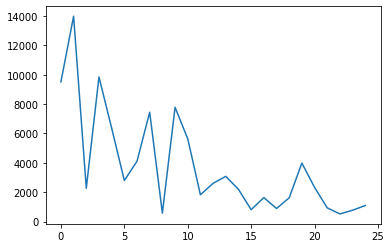

Epoch 1/25
17/17 - 4s - loss: 38253.1680 - accuracy: 0.5278 - auc_13: 0.5276 - precision_13: 0.5180 - recall_13: 0.6705 - f1_score: 0.5950 - val_loss: 1273.9951 - val_accuracy: 0.4713 - val_auc_13: 0.4944 - val_precision_13: 0.4444 - val_recall_13: 0.0292 - val_f1_score: 0.0541 - 4s/epoch - 234ms/step
Epoch 2/25
17/17 - 1s - loss: 4633.3037 - accuracy: 0.5202 - auc_13: 0.5257 - precision_13: 0.5303 - recall_13: 0.2713 - f1_score: 0.4103 - val_loss: 26618.2695 - val_accuracy: 0.4789 - val_auc_13: 0.5036 - val_precision_13: 1.0000 - val_recall_13: 0.0073 - val_f1_score: 0.0145 - 970ms/epoch - 57ms/step
Epoch 3/25
17/17 - 1s - loss: 28008.0156 - accuracy: 0.4607 - auc_13: 0.4597 - precision_13: 0.4450 - recall_13: 0.3605 - f1_score: 0.4109 - val_loss: 651.7332 - val_accuracy: 0.5249 - val_auc_13: 0.5004 - val_precision_13: 0.5251 - val_recall_13: 0.9927 - val_f1_score: 0.6869 - 846ms/epoch - 50ms/step
Epoch 4/25
17/17 - 1s - loss: 12473.9209 - accuracy: 0.5067 - auc_13: 0.5114 - precision

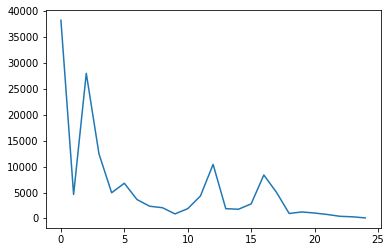

Epoch 1/25
17/17 - 4s - loss: 1896.5409 - accuracy: 0.5115 - auc_14: 0.5053 - precision_14: 0.5178 - recall_14: 0.6015 - f1_score: 0.6234 - val_loss: 24330.2500 - val_accuracy: 0.5192 - val_auc_14: 0.5058 - val_precision_14: 0.5093 - val_recall_14: 0.8527 - val_f1_score: 0.6632 - 4s/epoch - 240ms/step
Epoch 2/25
17/17 - 1s - loss: 1538.3077 - accuracy: 0.4981 - auc_14: 0.5239 - precision_14: 0.5071 - recall_14: 0.5376 - f1_score: 0.6693 - val_loss: 31215.3184 - val_accuracy: 0.5231 - val_auc_14: 0.4963 - val_precision_14: 0.5758 - val_recall_14: 0.1473 - val_f1_score: 0.6292 - 1s/epoch - 63ms/step
Epoch 3/25
17/17 - 1s - loss: 4.6728 - accuracy: 0.5690 - auc_14: 0.5691 - precision_14: 0.5844 - recall_14: 0.5338 - f1_score: 0.6754 - val_loss: 39810.3516 - val_accuracy: 0.5077 - val_auc_14: 0.5197 - val_precision_14: 0.5054 - val_recall_14: 0.3643 - val_f1_score: 0.6632 - 1s/epoch - 62ms/step
Epoch 4/25
17/17 - 1s - loss: 4.1677 - accuracy: 0.5479 - auc_14: 0.5472 - precision_14: 0.5595 

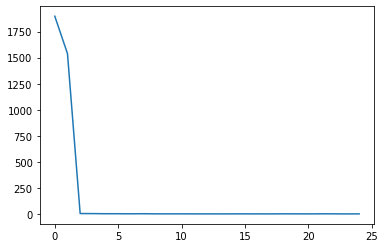

In [20]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = CNNLSTM(n_features, n_length, n_outputs)
    history = model.train(X_train, y_train, X_val, y_val, epochs, batch_size)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [21]:
y_pred = model.predict(X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(X_test, y_test)
cnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Accuracy: 74.79% 
ROC/AUC: 0.67 
Precision: 0.90 
Recall: 0.79 
F1 score: 0.90


### RCNN

In [22]:
class RCNN():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input)
        bn = TimeDistributed(BatchNormalization())(conv1d)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn)
        flatten = Flatten()(maxpool)
        dense = Dense(64, activation=PReLU(alpha_initializer=Constant(value=0.25)))(flatten)
        output = Dense(units=n_outputs, activation='sigmoid')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 2s - loss: 0.8414 - accuracy: 0.5336 - auc_15: 0.5320 - precision_15: 0.5380 - recall_15: 0.6128 - f1_score: 0.6760 - val_loss: 1.0528 - val_accuracy: 0.5172 - val_auc_15: 0.5579 - val_precision_15: 1.0000 - val_recall_15: 0.0233 - val_f1_score: 0.6512 - 2s/epoch - 97ms/step
Epoch 2/25
17/17 - 0s - loss: 0.8185 - accuracy: 0.5797 - auc_15: 0.5942 - precision_15: 0.5887 - recall_15: 0.5865 - f1_score: 0.6760 - val_loss: 0.6796 - val_accuracy: 0.5057 - val_auc_15: 0.4986 - val_precision_15: 0.5000 - val_recall_15: 1.0000 - val_f1_score: 0.6615 - 455ms/epoch - 27ms/step
Epoch 3/25
17/17 - 0s - loss: 0.6982 - accuracy: 0.5873 - auc_15: 0.6466 - precision_15: 0.6564 - recall_15: 0.4023 - f1_score: 0.6760 - val_loss: 0.6972 - val_accuracy: 0.5019 - val_auc_15: 0.5258 - val_precision_15: 0.4980 - val_recall_15: 0.9767 - val_f1_score: 0.6615 - 441ms/epoch - 26ms/step
Epoch 4/25
17/17 - 0s - loss: 0.7042 - accuracy: 0.5758 - auc_15: 0.6304 - precision_15: 0.6178 - recall_15: 

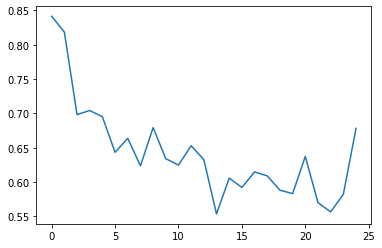

Epoch 1/25
17/17 - 2s - loss: 1.0775 - accuracy: 0.4760 - auc_16: 0.4836 - precision_16: 0.4729 - recall_16: 0.5078 - f1_score: 0.6624 - val_loss: 0.6839 - val_accuracy: 0.4866 - val_auc_16: 0.5951 - val_precision_16: 1.0000 - val_recall_16: 0.0219 - val_f1_score: 0.6884 - 2s/epoch - 98ms/step
Epoch 2/25
17/17 - 0s - loss: 0.7726 - accuracy: 0.5624 - auc_16: 0.5966 - precision_16: 0.5688 - recall_16: 0.4806 - f1_score: 0.6624 - val_loss: 0.7023 - val_accuracy: 0.5211 - val_auc_16: 0.5582 - val_precision_16: 0.5233 - val_recall_16: 0.9854 - val_f1_score: 0.6884 - 489ms/epoch - 29ms/step
Epoch 3/25
17/17 - 0s - loss: 0.7439 - accuracy: 0.5432 - auc_16: 0.5817 - precision_16: 0.5549 - recall_16: 0.3915 - f1_score: 0.6624 - val_loss: 0.6815 - val_accuracy: 0.5287 - val_auc_16: 0.5597 - val_precision_16: 0.5269 - val_recall_16: 1.0000 - val_f1_score: 0.6884 - 453ms/epoch - 27ms/step
Epoch 4/25
17/17 - 0s - loss: 0.8077 - accuracy: 0.5086 - auc_16: 0.5450 - precision_16: 0.5033 - recall_16: 

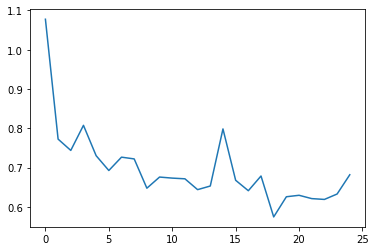

Epoch 1/25
17/17 - 2s - loss: 0.8862 - accuracy: 0.5326 - auc_17: 0.5415 - precision_17: 0.5355 - recall_17: 0.6241 - f1_score: 0.6751 - val_loss: 1.1170 - val_accuracy: 0.5038 - val_auc_17: 0.5636 - val_precision_17: 0.5000 - val_recall_17: 1.0000 - val_f1_score: 0.6632 - 2s/epoch - 97ms/step
Epoch 2/25
17/17 - 0s - loss: 0.7727 - accuracy: 0.5307 - auc_17: 0.5860 - precision_17: 0.5267 - recall_17: 0.7782 - f1_score: 0.6751 - val_loss: 1.0231 - val_accuracy: 0.5000 - val_auc_17: 0.5224 - val_precision_17: 0.4981 - val_recall_17: 1.0000 - val_f1_score: 0.6632 - 492ms/epoch - 29ms/step
Epoch 3/25
17/17 - 0s - loss: 0.7112 - accuracy: 0.5287 - auc_17: 0.5591 - precision_17: 0.5254 - recall_17: 0.7782 - f1_score: 0.6751 - val_loss: 0.8275 - val_accuracy: 0.5000 - val_auc_17: 0.4962 - val_precision_17: 0.4981 - val_recall_17: 0.9922 - val_f1_score: 0.6632 - 472ms/epoch - 28ms/step
Epoch 4/25
17/17 - 0s - loss: 0.6698 - accuracy: 0.5824 - auc_17: 0.6254 - precision_17: 0.5727 - recall_17: 

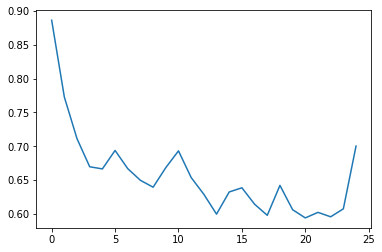

In [23]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = RCNN(n_features, n_length, n_outputs)
    history = model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [24]:
y_pred = model.predict(X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(X_test, y_test)
rnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Accuracy: 84.45% 
ROC/AUC: 0.57 
Precision: 0.85 
Recall: 0.99 
F1 score: 0.92


## 4. Multimodal Late Fusion

### Dataset

In [25]:
body_X_train, body_X_test, body_y_train, body_y_test = load_dataset('skeleton', binary=True, fusion=True)
body_X = body_X_train.copy()
body_y = body_y_train.copy()

print(body_X_train.shape, body_y_train.shape)
print(body_X_test.shape, body_y_test.shape)

(782, 1, 350, 35) (782, 1)
(238, 1, 350, 35) (238, 1)


In [26]:
face_X_train, face_X_test, face_y_train, face_y_test = load_dataset('AUs', binary=True)
face_X = face_X_train.copy()
face_y = face_y_train.copy()

print(face_X_train.shape, face_y_train.shape)
print(face_X_test.shape, face_y_test.shape)

(782, 1, 350, 25) (782, 1)
(238, 1, 350, 25) (238, 1)


In [27]:
n_length, body_features, face_features, n_outputs = face_X_train.shape[2], body_X_train.shape[-1], face_X_train.shape[-1], body_y_train.shape[1]

#### CNN + Bidirectional LSTM

In [28]:
class fusioned_CNNLSTM():
    def __init__(self, body_features, face_features, n_length, n_outputs):
        input_1 = Input(shape=(1, n_length, body_features))
        conv1d_1 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'))(input_1)
        maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_1)
        flatten_1 = TimeDistributed(Flatten())(maxpool_1)
        lstm_1 = LSTM(64)(flatten_1)
        dense_1 = Dense(64, activation='relu')(lstm_1)

        input_2 = Input(shape=(1, n_length, face_features))
        conv1d_2 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'))(input_2)
        maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_2)
        flatten_2 = TimeDistributed(Flatten())(maxpool_2)
        lstm_2 = LSTM(64)(flatten_2)
        dense_2 = Dense(64, activation='relu')(lstm_2)

        concat = Concatenate()([dense_1, dense_2])
        output = Dense(units=n_outputs, activation='sigmoid')(concat)
        model = Model(inputs=[input_1, input_2], outputs=[output])
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs, batch_size):
        history = self.model.fit([body_X_train, face_X_train], y_train, validation_data=([body_X_val, face_X_val], y_val), 
                            epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, body_X_test, face_X_test, y_test):
        results = self.model.evaluate([body_X_test, face_X_test], y_test, verbose=0)
        return results

    def predict(self, body_X_test, face_X_test):
        predictions = self.model.predict([body_X_test, face_X_test])
        return predictions

Epoch 1/25
17/17 - 6s - loss: 0.7047 - accuracy: 0.4702 - auc_18: 0.4662 - precision_18: 0.4684 - recall_18: 0.2782 - f1_score: 0.6760 - val_loss: 0.6943 - val_accuracy: 0.4981 - val_auc_18: 0.5349 - val_precision_18: 0.3333 - val_recall_18: 0.0155 - val_f1_score: 0.6615 - 6s/epoch - 349ms/step
Epoch 2/25
17/17 - 1s - loss: 0.6930 - accuracy: 0.5106 - auc_18: 0.5050 - precision_18: 0.5140 - recall_18: 0.7594 - f1_score: 0.6760 - val_loss: 0.7013 - val_accuracy: 0.4943 - val_auc_18: 0.5005 - val_precision_18: 0.4943 - val_recall_18: 1.0000 - val_f1_score: 0.6615 - 874ms/epoch - 51ms/step
Epoch 3/25
17/17 - 1s - loss: 0.6969 - accuracy: 0.5106 - auc_18: 0.4846 - precision_18: 0.5106 - recall_18: 1.0000 - f1_score: 0.6760 - val_loss: 0.6983 - val_accuracy: 0.4943 - val_auc_18: 0.5006 - val_precision_18: 0.4943 - val_recall_18: 1.0000 - val_f1_score: 0.6615 - 903ms/epoch - 53ms/step
Epoch 4/25
17/17 - 1s - loss: 0.6948 - accuracy: 0.5106 - auc_18: 0.5018 - precision_18: 0.5106 - recall_18:

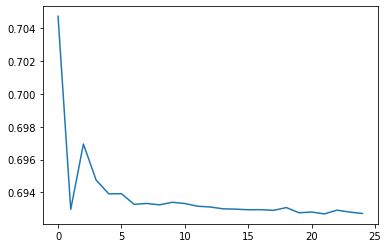

Epoch 1/25
17/17 - 5s - loss: 0.6968 - accuracy: 0.4952 - auc_19: 0.4905 - precision_19: 0.4944 - recall_19: 0.8488 - f1_score: 0.6624 - val_loss: 0.6929 - val_accuracy: 0.4789 - val_auc_19: 0.5313 - val_precision_19: 0.5294 - val_recall_19: 0.0657 - val_f1_score: 0.6884 - 5s/epoch - 308ms/step
Epoch 2/25
17/17 - 1s - loss: 0.6945 - accuracy: 0.4894 - auc_19: 0.4796 - precision_19: 0.3000 - recall_19: 0.0233 - f1_score: 0.6624 - val_loss: 0.6940 - val_accuracy: 0.4828 - val_auc_19: 0.5146 - val_precision_19: 0.6667 - val_recall_19: 0.0292 - val_f1_score: 0.6884 - 898ms/epoch - 53ms/step
Epoch 3/25
17/17 - 1s - loss: 0.6936 - accuracy: 0.4971 - auc_19: 0.4465 - precision_19: 0.3750 - recall_19: 0.0233 - f1_score: 0.6624 - val_loss: 0.6944 - val_accuracy: 0.4713 - val_auc_19: 0.5040 - val_precision_19: 0.3333 - val_recall_19: 0.0073 - val_f1_score: 0.6884 - 796ms/epoch - 47ms/step
Epoch 4/25
17/17 - 1s - loss: 0.6938 - accuracy: 0.4990 - auc_19: 0.4559 - precision_19: 0.3333 - recall_19:

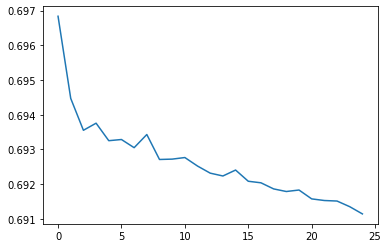

Epoch 1/25
17/17 - 4s - loss: 0.7066 - accuracy: 0.4885 - auc_20: 0.5752 - precision_20: 0.0000e+00 - recall_20: 0.0000e+00 - f1_score: 0.6751 - val_loss: 0.7002 - val_accuracy: 0.5038 - val_auc_20: 0.5075 - val_precision_20: 0.0000e+00 - val_recall_20: 0.0000e+00 - val_f1_score: 0.6632 - 4s/epoch - 250ms/step
Epoch 2/25
17/17 - 1s - loss: 0.7033 - accuracy: 0.4828 - auc_20: 0.4571 - precision_20: 0.0000e+00 - recall_20: 0.0000e+00 - f1_score: 0.6751 - val_loss: 0.6943 - val_accuracy: 0.5000 - val_auc_20: 0.5075 - val_precision_20: 0.0000e+00 - val_recall_20: 0.0000e+00 - val_f1_score: 0.6632 - 843ms/epoch - 50ms/step
Epoch 3/25
17/17 - 1s - loss: 0.6965 - accuracy: 0.4962 - auc_20: 0.4983 - precision_20: 0.5066 - recall_20: 0.4323 - f1_score: 0.6751 - val_loss: 0.6925 - val_accuracy: 0.5077 - val_auc_20: 0.5114 - val_precision_20: 0.5019 - val_recall_20: 1.0000 - val_f1_score: 0.6632 - 873ms/epoch - 51ms/step
Epoch 4/25
17/17 - 1s - loss: 0.6949 - accuracy: 0.5038 - auc_20: 0.4526 - p

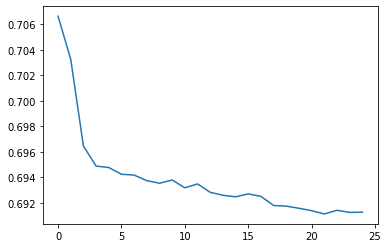

In [29]:
for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    body_y_train, body_y_val = body_y[train_index], body_y[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    face_y_train, face_y_val = face_y[train_index], face_y[val_index]
    model = fusioned_CNNLSTM(body_features, face_features, n_length, n_outputs)
    history = model.train(body_X_train, face_X_train, body_y_train, body_X_val, face_X_val, face_y_val, epochs, batch_size)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [30]:
y_pred = model.predict(body_X_test, face_X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(body_X_test, face_X_test, y_test)
cnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Accuracy: 81.09% 
ROC/AUC: 0.52 
Precision: 0.85 
Recall: 0.95 
F1 score: 0.92


#### RCNN

In [31]:
class fusioned_RCNN():
    def __init__(self, body_features, face_features, n_length, n_outputs):
        input_1 = Input(shape=(1, n_length, body_features))
        conv1d_1 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input_1)
        bn_1 = TimeDistributed(BatchNormalization())(conv1d_1)
        maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_1)
        flatten_1 = Flatten()(maxpool_1)
        dense_1 = Dense(256)(flatten_1)

        input_2 = Input(shape=(1, n_length, face_features))
        conv1d_2 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input_2)
        bn_2 = TimeDistributed(BatchNormalization())(conv1d_2)
        maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_2)
        flatten_2 = Flatten()(maxpool_2)
        dense_2 = Dense(256)(flatten_2)

        concat = Concatenate()([dense_1, dense_2])
        output = Dense(units=n_outputs, activation='sigmoid')(concat)
        model = Model(inputs=[input_1, input_2], outputs=[output])
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs, batch_size):
        history = self.model.fit([body_X_train, face_X_train], y_train, validation_data=([body_X_val, face_X_val], y_val), 
                            epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, body_X_test, face_X_test, y_test):
        results = self.model.evaluate([body_X_test, face_X_test], y_test, verbose=0)
        return results

    def predict(self, body_X_test, face_X_test):
        predictions = self.model.predict([body_X_test, face_X_test])
        return predictions

Epoch 1/25
17/17 - 3s - loss: 2.3248 - accuracy: 0.5701 - auc_21: 0.5953 - precision_21: 0.5766 - recall_21: 0.5940 - f1_score: 0.6760 - val_loss: 29.8792 - val_accuracy: 0.4943 - val_auc_21: 0.5000 - val_precision_21: 0.4943 - val_recall_21: 1.0000 - val_f1_score: 0.6615 - 3s/epoch - 185ms/step
Epoch 2/25
17/17 - 1s - loss: 1.4232 - accuracy: 0.6411 - auc_21: 0.6776 - precision_21: 0.6406 - recall_21: 0.6767 - f1_score: 0.6760 - val_loss: 10.9345 - val_accuracy: 0.4943 - val_auc_21: 0.5000 - val_precision_21: 0.4943 - val_recall_21: 1.0000 - val_f1_score: 0.6615 - 1s/epoch - 61ms/step
Epoch 3/25
17/17 - 1s - loss: 1.1660 - accuracy: 0.6430 - auc_21: 0.6749 - precision_21: 0.6587 - recall_21: 0.6241 - f1_score: 0.6786 - val_loss: 9.8324 - val_accuracy: 0.5057 - val_auc_21: 0.5148 - val_precision_21: 0.5000 - val_recall_21: 0.9845 - val_f1_score: 0.6632 - 1s/epoch - 65ms/step
Epoch 4/25
17/17 - 1s - loss: 0.9629 - accuracy: 0.6737 - auc_21: 0.7225 - precision_21: 0.6846 - recall_21: 0.6

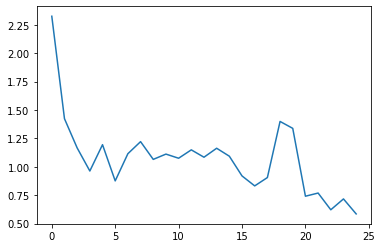

Epoch 1/25
17/17 - 3s - loss: 1.9274 - accuracy: 0.6027 - auc_22: 0.6567 - precision_22: 0.6000 - recall_22: 0.5930 - f1_score: 0.6624 - val_loss: 29.1903 - val_accuracy: 0.5249 - val_auc_22: 0.5000 - val_precision_22: 0.5249 - val_recall_22: 1.0000 - val_f1_score: 0.6884 - 3s/epoch - 172ms/step
Epoch 2/25
17/17 - 1s - loss: 1.6380 - accuracy: 0.6008 - auc_22: 0.6668 - precision_22: 0.5893 - recall_22: 0.6395 - f1_score: 0.6658 - val_loss: 4.5968 - val_accuracy: 0.5441 - val_auc_22: 0.5363 - val_precision_22: 0.5405 - val_recall_22: 0.8759 - val_f1_score: 0.6851 - 1s/epoch - 70ms/step
Epoch 3/25
17/17 - 1s - loss: 1.5722 - accuracy: 0.6583 - auc_22: 0.6794 - precision_22: 0.6709 - recall_22: 0.6085 - f1_score: 0.6658 - val_loss: 6.3436 - val_accuracy: 0.4981 - val_auc_22: 0.5307 - val_precision_22: 0.7500 - val_recall_22: 0.0657 - val_f1_score: 0.6835 - 1s/epoch - 67ms/step
Epoch 4/25
17/17 - 1s - loss: 1.3283 - accuracy: 0.6833 - auc_22: 0.7276 - precision_22: 0.6768 - recall_22: 0.68

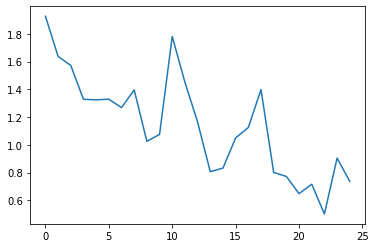

Epoch 1/25
17/17 - 3s - loss: 2.8334 - accuracy: 0.5785 - auc_23: 0.6080 - precision_23: 0.5865 - recall_23: 0.5865 - f1_score: 0.6735 - val_loss: 12.6129 - val_accuracy: 0.5000 - val_auc_23: 0.5115 - val_precision_23: 0.4981 - val_recall_23: 1.0000 - val_f1_score: 0.6632 - 3s/epoch - 170ms/step
Epoch 2/25
17/17 - 1s - loss: 1.8596 - accuracy: 0.6226 - auc_23: 0.6504 - precision_23: 0.6264 - recall_23: 0.6429 - f1_score: 0.6718 - val_loss: 11.8915 - val_accuracy: 0.5000 - val_auc_23: 0.5038 - val_precision_23: 0.4981 - val_recall_23: 1.0000 - val_f1_score: 0.6632 - 1s/epoch - 68ms/step
Epoch 3/25
17/17 - 1s - loss: 0.8792 - accuracy: 0.6513 - auc_23: 0.7289 - precision_23: 0.6654 - recall_23: 0.6353 - f1_score: 0.6777 - val_loss: 1.7986 - val_accuracy: 0.6115 - val_auc_23: 0.6494 - val_precision_23: 0.5700 - val_recall_23: 0.8837 - val_f1_score: 0.6649 - 1s/epoch - 61ms/step
Epoch 4/25
17/17 - 1s - loss: 0.7985 - accuracy: 0.6782 - auc_23: 0.7360 - precision_23: 0.6842 - recall_23: 0.6

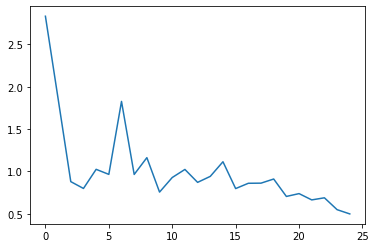

In [32]:
for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    body_y_train, body_y_val = body_y[train_index], body_y[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    face_y_train, face_y_val = face_y[train_index], face_y[val_index]
    model = fusioned_RCNN(body_features, face_features, n_length, n_outputs)
    history = model.train(body_X_train, face_X_train, body_y_train, body_X_val, face_X_val, face_y_val, epochs, batch_size)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [33]:
y_pred = model.predict(body_X_test, face_X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(body_X_test, face_X_test, body_y_test)
rnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Accuracy: 40.76% 
ROC/AUC: 0.55 
Precision: 0.90 
Recall: 0.34 
F1 score: 0.92


### Ensemble

In [34]:
class KerasMember():
    def __init__(self, name=None, keras_model=None, train_batches=None,
                 val_batches=None, submission_probs=None, keras_modelpath=None,
                 keras_kwargs={}):
        assert(name is not None)
        self.name = name
        self.model = keras_model
        self.submission_probs = submission_probs
        # Initialize Params
        self.val_probs = None
        self.train_probs = None
        self.val_classes = None
        self.train_classes = None
        if (keras_model is None) and (keras_modelpath is not None):
            self.load_kerasmodel(self.keras_modelpath, self.keras_kwargs)
        if train_batches is not None:
            self._calculate_train_predictions(train_batches)
        if val_batches is not None:
            self._calculate_val_predictions(val_batches)

    def _test_datatuple(self, datatuple):
        assert(len(datatuple) == 2)
        assert(datatuple[0].shape[0] == datatuple[1].shape[0])

    def _calculate_predictions(self, batches):
        if hasattr(batches, 'shuffle'):
            batches.reset()
            batches.shuffle = False
        if type(batches) is tuple:
            self._test_datatuple(batches)
            return self.model.predict(batches[0])
        return self.model.predict_generator(
            batches, steps=(batches.n // batches.batch_size) + 1, verbose=1)

    def _calculate_val_predictions(self, val_batches):
        if type(val_batches) is tuple:
            self.val_classes = val_batches[1]
        elif hasattr(val_batches, 'classes'):
            self.val_classes = np.array(val_batches.classes)
        elif hasattr(val_batches, 'y'):
            self.val_classes = np.array(val_batches.y)
        else:
            raise ValueError("No known class in data batch")
        self.val_probs = self._calculate_predictions(val_batches)
        return self.val_probs

    def _calculate_train_predictions(self, train_batches):
        if type(train_batches) is tuple:
            self.train_classes = train_batches[1]
        elif hasattr(train_batches, 'classes'):
            self.train_classes = np.array(train_batches.classes)
        elif hasattr(train_batches, 'y'):
            self.train_classes = np.array(train_batches.y)
        else:
            raise ValueError("No known class in data batch")
        self.train_probs = self._calculate_predictions(train_batches)
        return self.train_probs


def _calculate_metric(y_true, y_pred, metric=None):
    if metric is None:
        metric = roc_auc_score
    y_t = y_true
    y_p = y_pred
    if metric == roc_auc_score:
        return metric(y_t, y_p, multi_class='ovo')
    if y_true.ndim > 1:
        y_t = np.argmax(y_true, axis=1)
    if y_pred.ndim > 1:
        y_p = np.argmax(y_pred, axis=1)
    if metric is precision_recall_fscore_support:
        return precision_recall_fscore_support(y_t, y_p, average='macro')
    return metric(y_t, y_p)

class DirichletEnsemble():
    def __init__(self, N=10000, metric=None, maximize=True):
        self.n = N
        self.metric = metric
        if metric is None:
            self.metric = roc_auc_score
        self.maximize = maximize
        # Initialize Parameters:
        self.members = []
        self.bestweights = []
        self.probabilities = None
        self._nmembers = 0
        self.bestscore = float("-inf") if maximize else float("inf")
        self.accuracy = None
        self.precision = None
        self.recall = None
        self.f1 = None
        self.fitted = False

    def add_members(self, members):
        for member in members:
            self.add_member(member)

    def add_member(self, member):
        self.members.append(member)
        self._nmembers += 1

    def fit(self, verbose=False):
        assert(len(self.members) > 1)
        val_classes = self.members[0].val_classes
        best_ensemble_score = float("-inf") if self.maximize else float("inf")
        best_ensemble_accuracy = 0
        best_ensemble_p = 0
        best_ensemble_r = 0
        best_ensemble_f1 = 0
        rsbest = None
        for i in range(self.n):
            rs = np.random.dirichlet(np.ones(self._nmembers), size=1)[0]
            preds = np.sum(np.array([self.members[i].val_probs * rs[i]
                                     for i in range(self._nmembers)]), axis=0)
            ensemble_score = _calculate_metric(val_classes, preds)
            ensemble_accuracy = _calculate_metric(val_classes, preds, accuracy_score)
            ensemble_prf1 = _calculate_metric(val_classes, preds, precision_recall_fscore_support)
            ensemble_p = ensemble_prf1[0]
            ensemble_r = ensemble_prf1[1]
            ensemble_f1 = ensemble_prf1[2]
            max_flag = self.maximize and ensemble_score > best_ensemble_score
            min_flag = not(
                self.maximize) and ensemble_score < best_ensemble_score
            if max_flag or min_flag:
                if verbose:
                    print(ensemble_score, i, rs) 
                best_ensemble_score = ensemble_score
                rsbest = rs
            if ensemble_accuracy > best_ensemble_accuracy:
                if verbose:
                    print(ensemble_accuracy, i, rs) 
                best_ensemble_accuracy = ensemble_accuracy
            if ensemble_p > best_ensemble_p:
                if verbose:
                    print(ensemble_p, i, rs) 
                best_ensemble_p = ensemble_p
            if ensemble_r > best_ensemble_r:
                if verbose:
                    print(ensemble_r, i, rs) 
                best_ensemble_r = ensemble_r
            if ensemble_f1 > best_ensemble_f1:
                if verbose:
                    print(ensemble_f1, i, rs) 
                best_ensemble_f1 = ensemble_f1
        self.bestweights = rsbest
        self.bestscore = best_ensemble_score
        self.accuracy = best_ensemble_accuracy
        self.precision = best_ensemble_p
        self.recall = best_ensemble_r
        self.f1 = best_ensemble_f1

    def predict(self):
        self.probabilities = np.sum(np.array([self.bestweights[i] *
                                              self.members[i].submission_probs
                                              for i in range(self._nmembers)]),
                                    axis=0)
        return self.probabilities
        
    def describe(self):
        for i in range(self._nmembers):
            member = self.members[i]
            text = member.name + " (weight: {:1.4f})".format(self.bestweights[i])
            print(text)
        print("Accuracy: {:1.2f}% - ROC/AUC: {:1.2f} - Precision: {:1.2f} - Recall: {:1.2f} - F1 score: {:1.2f}".format(
            self.accuracy * 100, self.bestscore, self.precision, self.recall, self.f1))
        return self.bestscore

In [35]:
cnnlstm_body_member = KerasMember(name="CNN + Bidirectional LSTM Body Model", keras_model=cnnlstm_binary_body_model, train_batches=(body_X_train, y_train), val_batches=(body_X_test, body_y_test))
rcnn_body_member = KerasMember(name="RCNN Body Model", keras_model=rcnn_binary_body_model, train_batches=(body_X_train, body_y_train), val_batches=(body_X_test, body_y_test))
cnnlstm_face_member = KerasMember(name="CNN + Bidirectional LSTM Face Model", keras_model=cnnlstm_binary_face_model, train_batches=(face_X_train, face_y_train), val_batches=(face_X_test, face_y_test))
rcnn_face_member = KerasMember(name="RCNN Face Model", keras_model=rcnn_binary_face_model, train_batches=(face_X_train, face_y_train), val_batches=(face_X_test, face_y_test))

In [36]:
dirichletEnsemble = DirichletEnsemble()
dirichletEnsemble.add_member(cnnlstm_body_member)
dirichletEnsemble.add_member(rcnn_body_member)
dirichletEnsemble.add_member(cnnlstm_face_member)
dirichletEnsemble.add_member(rcnn_face_member)
dirichletEnsemble.fit()

In [37]:
e = dirichletEnsemble.describe()
cnn_auc.append(round(e, 2))
rnn_auc.append(0)

CNN + Bidirectional LSTM Body Model (weight: 0.6068)
RCNN Body Model (weight: 0.0107)
CNN + Bidirectional LSTM Face Model (weight: 0.1080)
RCNN Face Model (weight: 0.2745)
Accuracy: 100.00% - ROC/AUC: 0.74 - Precision: 1.00 - Recall: 1.00 - F1 score: 1.00


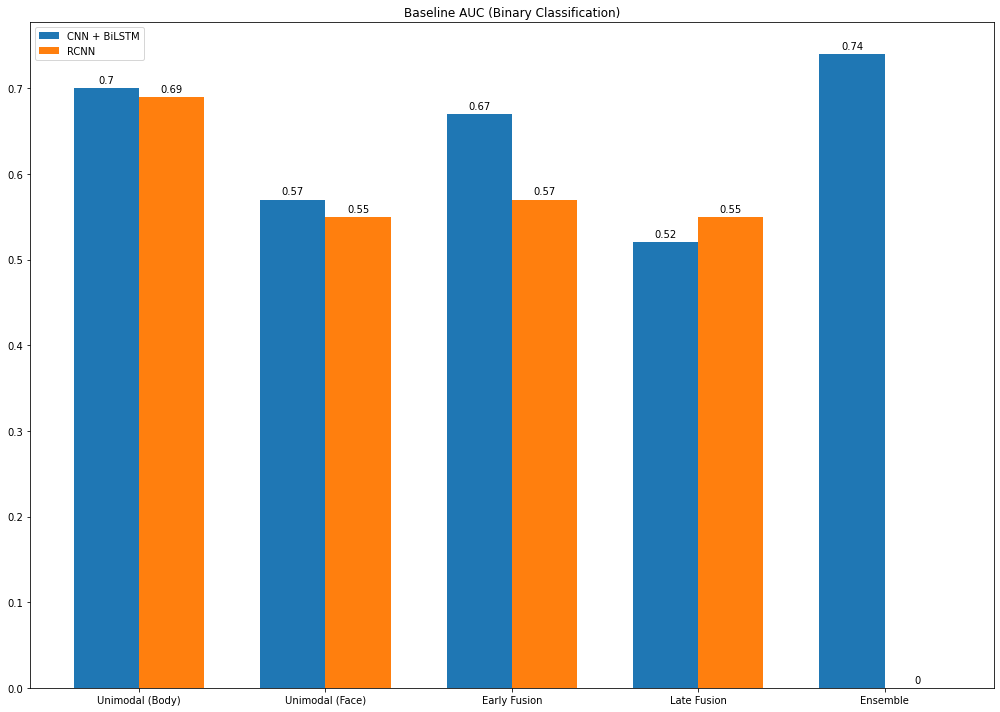

In [38]:
labels = ['Unimodal (Body)', 'Unimodal (Face)', 'Early Fusion', 'Late Fusion', 'Ensemble']
men_means = cnn_auc
women_means = rnn_auc

x = np.arange(len(labels)) 
width = 0.35 

fig, ax = plt.subplots(figsize=(14, 10))
rects1 = ax.bar(x - width/2, men_means, width, label='CNN + BiLSTM')
rects2 = ax.bar(x + width/2, women_means, width, label='RCNN')

ax.set_title('Baseline AUC (Binary Classification)')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()